# LGBM Train



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/RecSys2024/'
!pip3 install polars lightgbm pyarrow optuna optuna-integration

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#DEBUG_MODE = True
DEBUG_MODE = False
#OPTUNA_FLAG = True
OPTUNA_FLAG = False
#TRAIN_FRAC = 1.0 # train dataをどれくらいsamplingするか
#TRAIN_FRAC = 0.7 # train dataをどれくらいsamplingするか
TRAIN_FRAC = 0.6 # train dataeをどれくらいsamplingするか
#TRAIN_FRAC = 0.5 # train dataeをどれくらいsamplingするか
#TRAIN_FRAC = 0.3 # ハイパラチューニング用
VALID_FRAC = 0.25 # validatoin dataをどれくらいsamplingするか
#VALID_FRAC = 0.20 # ハイパラチューニング用

#RANDOM_SEED = 42 # 学習ときのseed
#RANDOM_SEED = 52 # 学習ときのsee
RANDOM_SEED = 62 # 学習ときのsee

TRAIN_NEG_FRAC = 1.0 # train dataのnegative sampleをどれくらいsamplingするか
#TRAIN_NEG_FRAC = 0.8 # train dataのnegative sampleをどれくらいsamplingするか
if DEBUG_MODE:
    TRAIN_FRAC = 1.0
    VALID_FRAC = 1.0

#train_type = 'train'
train_type = 'valid' # use validation data as training for final sub

In [ ]:
# ==================================================== # Library # ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import polars as pl
import joblib
import pyarrow
import itertools
from datetime import timedelta
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, log_loss
# optuna
if OPTUNA_FLAG:
    import optuna.integration.lightgbm as lgb
else:
    import lightgbm as lgb
    print(lgb.__version__)

4.4.0


# Reading Input File

In [ ]:
out_path = base_path + 'feature_output'
bins = [600, 3600, 3600 * 6]
#bins = [300, 600, 3600, 3600 * 6]
#bins = []

# Feature Engineering

In [ ]:
def read_files(train_type = 'train'):
    if DEBUG_MODE:
        impression = pl.read_parquet(f"{out_path}/small_{train_type}_impression.parquet")
        #impression_article = pl.read_parquet(f"{out_path}/small_{train_type}_impression_article.parquet")
        impression_article = pl.read_parquet(f"{out_path}/small_{train_type}_impression_article_w_embed.parquet")
        user = pl.read_parquet(f"{out_path}/small_{train_type}_user.parquet")
        user_article = pl.read_parquet(f"{out_path}/small_{train_type}_user_article.parquet")
        article = pl.read_parquet(f"{out_path}/small_{train_type}_article.parquet")
        session = pl.read_parquet(f"{out_path}/small_{train_type}_session.parquet")
    else:
        impression = pl.read_parquet(f"{out_path}/{train_type}_impression.parquet")
        #impression_article = pl.read_parquet(f"{out_path}/{train_type}_impression_article.parquet")
        impression_article = pl.read_parquet(f"{out_path}/{train_type}_impression_article_w_embed.parquet")
        user = pl.read_parquet(f"{out_path}/{train_type}_user.parquet")
        user_article = pl.read_parquet(f"{out_path}/{train_type}_user_article.parquet")
        article = pl.read_parquet(f"{out_path}/{train_type}_article.parquet")
        session = pl.read_parquet(f"{out_path}/{train_type}_session.parquet")
    return impression_article, impression, user, user_article, article, session


def add_pop_count(df, out_col_name, bins):

    # articleごとの全体の時間ごとのviewの数
    for bin in bins:
        df = df.with_columns(
            (df["impression_time"] / bin).cast(pl.Int64).alias(f"time_bin_{bin}")
        )
        grouped_df = df.group_by([f"time_bin_{bin}", "article_id_inview"]).agg(
            pl.count().cast(pl.Int32).alias(out_col_name + str(bin))
        )
        df = df.join(
            grouped_df,
            on=[f"time_bin_{bin}", "article_id_inview"],
            how="left"
        )
        df = df.drop(f"time_bin_{bin}")

    # userごとにviewのあったarticleのview数 (未来の情報含む)
    key = ['user_id', 'article_id_inview']
    tmp = df.group_by(key).agg([
            pl.col('impression_time').mean().alias('imp_time_mean'),
            pl.col('impression_time').std().alias('imp_time_std'),
            pl.col('impression_time').max().alias('imp_time_max'),
            pl.col('impression_time').min().alias('imp_time_min'),
            pl.col('impression_time').count().alias('imp_time_cnt'),
        ])
    tmp = reduce_mem_usage(tmp)
    df = df.join(tmp, on=['user_id', 'article_id_inview'], how='left')
    del tmp
    gc.collect()

    df = df.with_columns(
        (pl.col('impression_time') - pl.col('imp_time_mean')).alias('diff_imp_time_mean').cast(pl.Int64),
        (pl.col('imp_time_max') - pl.col('impression_time')).alias('diff_imp_time_max'),
        (pl.col('impression_time') - pl.col('imp_time_min')).alias('diff_imp_time_min'),
    )
    df = df.drop(['imp_time_mean', 'imp_time_max', 'imp_time_min'])
    df = reduce_mem_usage(df)

    return df


def join_features(impression_article, impression, user, user_article, article, session, bins):
    print('join features....')
    #df = impression_article.select("impression_id", "article_id_inview", "clicked").join(impression, on="impression_id", how="inner")
    df = impression_article.join(impression, on=["impression_id", "user_id"], how="inner")
    del impression_article
    gc.collect()
    df = reduce_mem_usage(df)

    print('add view_cnt....')
    df = add_pop_count(df,"view_cnt", bins)
    df = reduce_mem_usage(df)

    print('add user features....')
    df = df.join(user, on="user_id", how="left")
    del user
    gc.collect()
    df = reduce_mem_usage(df)

    print('add article features....')
    df = df.rename({
        "article_id_inview": "article_id"
    })
    df = df.join(
        #article.rename({col: f"to_{col}" for col in article.columns}),
        article,
        on="article_id",
        how="left"
    )
    del article
    gc.collect()
    df = reduce_mem_usage(df)

    print('add user article features....')
    df = df.join(
        #user_article.rename({col: f"to_{col}" for col in user_article.columns if col != 'user_id'}),
        user_article,
        on=["user_id", "article_id"],
        how="left"
    )
    #df = df.drop(['user_id', 'article_id'])
    del user_article
    gc.collect()
    df = reduce_mem_usage(df)

    print('add session features....')
    df = df.join(
        #user_article.rename({col: f"to_{col}" for col in user_article.columns if col != 'user_id'}),
        session,
        on=["impression_id", "user_id", "article_id"],
        how="left"
    )
    #df = df.drop(['user_id', 'article_id'])
    del session
    gc.collect()
    df = reduce_mem_usage(df)

    print('cast features....')
    for bin in bins:
        df = df.with_columns(
            pl.col(f"view_cnt{bin}").fill_null(0).cast(pl.Int32)
        )
    df = reduce_mem_usage(df)
    return df


def generate_unixtime_features(df, unixtime_list):

    for col_name in unixtime_list:
        df = df.with_columns(
            (pl.col("impression_time") - pl.col(col_name)).alias(f"{col_name}_diff").cast(pl.Int64)
        )
        df = df.drop(col_name)
    df = df.drop('impression_time')
    df = reduce_mem_usage(df)
    return df


def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data
    #return df_data, cat_cols


def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage in Polars.
    """

    # Initialize an empty list to store optimized columns
    optimized_columns = []

    for col in df.columns:
        col_data = df[col]
        col_type = col_data.dtype

        if col_type in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt32]:
            col_data = col_data.fill_null(0)
            c_min = col_data.min()
            c_max = col_data.max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                optimized_columns.append(col_data.cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                optimized_columns.append(col_data.cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                optimized_columns.append(col_data.cast(pl.Int32))
            else:
                optimized_columns.append(col_data.cast(pl.Int64))
        elif col_type in [pl.Float32, pl.Float64]:
            c_min = col_data.min()
            c_max = col_data.max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                optimized_columns.append(col_data.cast(pl.Float32))
            else:
                optimized_columns.append(col_data.cast(pl.Float64))
        else:
            optimized_columns.append(col_data)
    # Create a new DataFrame with optimized columns
    optimized_df = pl.DataFrame({col: optimized_columns[i] for i, col in enumerate(df.columns)})

    return optimized_df


def cast_float_to_int(df, columns):
    for col in columns:
        df = df.with_columns(pl.col(col).cast(pl.Int64))
    return df


def negative_sampling(df, frac=0.5, seed=RANDOM_SEED):
    negative_examples = df.filter(pl.col("clicked") == False)
    positive_examples = df.filter(pl.col("clicked") == True)
    reduced_negatives = negative_examples.sample(fraction = frac, seed=seed)

    return pl.concat([reduced_negatives, positive_examples]).sort("impression_id")


def add_features(df, cols, key, prefix, df_origin = None):
    tmp = df.group_by(key).agg([
        pl.col(cols).mean(),
    ])
    new_cols = [prefix + name + "_mean" if name != key else name for name in cols]
    tmp = tmp.rename(dict(zip(cols, new_cols)))
    tmp = reduce_mem_usage(tmp)
    # joinする元のdfが異なる場合は最後の引数を指定する
    if df_origin is not None:
        df = df_origin
    df = df.join(tmp, on=key, how='left')
    del tmp
    gc.collect()

    # 差分のfeatureを追加
    for i, j in zip(cols, new_cols):
      df = df.with_columns(
          (pl.col(i) - pl.col(j)).alias('diff_' + j)
      )
    df = reduce_mem_usage(df)
    return df

def join_all_process(train_type='train'):

    impression_article, impression, user, user_article, article, session = read_files(train_type=train_type)
    # validはデータ量が多いので半分に削る
    if train_type == 'train':
      frac = TRAIN_FRAC
    else:
      frac = VALID_FRAC
    impression = impression.sample(fraction=frac, seed=RANDOM_SEED)
    float_int_cols = ['read_time', 'scroll_percentage']
    impression = cast_float_to_int(impression, float_int_cols)
    impression = reduce_mem_usage(impression)
    impression_article = reduce_mem_usage(impression_article)

    float_int_cols = ['u_read_time_last', 'u_scroll_percentage_last', 'u_impression_time_mean']
    user = cast_float_to_int(user, float_int_cols)
    user = reduce_mem_usage(user)

    float_int_cols = ['ua_read_time_last', 'ua_scroll_percentage_last']
    user_article = cast_float_to_int(user_article, float_int_cols)
    user_article = reduce_mem_usage(user_article)

    float_int_cols = ['a_total_read_time']
    article = cast_float_to_int(article, float_int_cols)
    article = reduce_mem_usage(article)

    session = reduce_mem_usage(session)

    df = join_features(impression_article, impression, user, user_article, article, session, bins)
    del impression_article, impression, user
    gc.collect()

    print('add user features group_by article impression basis, add diff features....')
    cols = ['read_time', 'scroll_percentage','device_type', 'is_sso_user', 'gender', 'postcode', 'age', 'is_subscriber', 'view_num']
    df = add_features(df, cols=cols, key='article_id', prefix='a_')

    print('add article features group_by user impression basis, add diff features....')
    cols = ["premium", "total_inviews", "total_pageviews", "total_read_time", "sentiment_score", "title_len", "subtitle_len", "body_len", "image_ids_len", "ner_clusters_len", "entity_groups_len", "topics_len", "subcategory_len"]
    cols = ['a_' + i for i in cols]
    df = add_features(df, cols=cols, key='user_id', prefix='u_')

    print('add article features group_by user click history basis, add diff features....')
    user_hist = user_article.select("user_id", "article_id")
    del user_article
    gc.collect()

    user_hist = user_hist.join(article, on='article_id', how='left')
    del article
    gc.collect()

    user_hist = reduce_mem_usage(user_hist)
    df = add_features(user_hist, cols=cols, key='user_id', prefix='u_hist_', df_origin=df)
    del user_hist
    gc.collect()
    return df


In [ ]:
valid = join_all_process('valid')

join features....
add view_cnt....
add user features....
add article features....
add user article features....
add session features....
cast features....
add user features group_by article impression basis, add diff features....
add article features group_by user impression basis, add diff features....
add article features group_by user click history basis, add diff features....


In [ ]:
if train_type == 'train':
    train = join_all_process('train')
else:
    train = valid

In [ ]:
# unixtimeのfeatureをdiffにする
unixtime_list = ['u_impression_time_last', 'u_impression_time_mean', 'ua_impression_time_mean', 'ua_impression_time_last', 'a_published_time', 'a_last_modified_time']
train = generate_unixtime_features(train, unixtime_list)
valid = generate_unixtime_features(valid, unixtime_list)

In [ ]:
print(train.shape)
train.head()

(37545285, 147)


impression_id,user_id,article_id,clicked,sim_xlm-roberta-base_pca16_5hist,sim_title_vector_pca16_5hist,read_time,scroll_percentage,device_type,is_sso_user,gender,postcode,age,is_subscriber,session_id,ndays,seconds_since_midnight,view_num,view_cnt600,view_cnt3600,view_cnt21600,imp_time_std,imp_time_cnt,diff_imp_time_mean,diff_imp_time_max,diff_imp_time_min,u_history_len,u_read_time_last,u_read_time_mean,u_scroll_percentage_last,u_scroll_percentage_mean,a_premium,a_article_type,a_category,a_category_str,a_total_inviews,a_total_pageviews,…,diff_u_a_image_ids_len_mean,diff_u_a_ner_clusters_len_mean,diff_u_a_entity_groups_len_mean,diff_u_a_topics_len_mean,diff_u_a_subcategory_len_mean,u_hist_a_premium_mean,u_hist_a_total_inviews_mean,u_hist_a_total_pageviews_mean,u_hist_a_total_read_time_mean,u_hist_a_sentiment_score_mean,u_hist_a_title_len_mean,u_hist_a_subtitle_len_mean,u_hist_a_body_len_mean,u_hist_a_image_ids_len_mean,u_hist_a_ner_clusters_len_mean,u_hist_a_entity_groups_len_mean,u_hist_a_topics_len_mean,u_hist_a_subcategory_len_mean,diff_u_hist_a_premium_mean,diff_u_hist_a_total_inviews_mean,diff_u_hist_a_total_pageviews_mean,diff_u_hist_a_total_read_time_mean,diff_u_hist_a_sentiment_score_mean,diff_u_hist_a_title_len_mean,diff_u_hist_a_subtitle_len_mean,diff_u_hist_a_body_len_mean,diff_u_hist_a_image_ids_len_mean,diff_u_hist_a_ner_clusters_len_mean,diff_u_hist_a_entity_groups_len_mean,diff_u_hist_a_topics_len_mean,diff_u_hist_a_subcategory_len_mean,u_impression_time_last_diff,u_impression_time_mean_diff,ua_impression_time_mean_diff,ua_impression_time_last_diff,a_published_time_diff,a_last_modified_time_diff
i32,i32,i32,bool,f32,f32,i16,i8,i8,bool,i8,i8,i8,bool,i32,i8,i16,u8,i16,i16,i32,f32,i8,i32,i32,i32,i16,i16,f32,i8,f32,bool,str,i16,str,i32,i32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,i32,i32
96556,21945,9784662,false,-0.11191,-0.08727,21,0,2,false,0,0,0,false,711,2,14510,10,621,2956,11891,null,1,46,0,0,332,0,52.587349,14,48.811386,false,"""article_default""",140,"""krimi""",551567,108201,…,-2.014085,-4.239436,-4.239436,0.295775,-1.28169,0.106007,580747.125,118371.539062,7.272229e6,0.851432,43.964664,120.939926,2225.173096,2.636042,10.477032,10.477032,3.964664,1.360424,-0.106007,-29180.125,-10170.539062,-1.360987e6,0.139168,2.035336,-22.939926,-130.173096,-1.636042,-3.477032,-3.477032,0.035336,-1.360424,253307,1097646,0,1685247534,32444,-2773814
96556,21945,9784406,false,0.108502,0.041542,21,0,2,false,0,0,0,false,711,2,14510,10,423,3205,11118,null,1,46,0,0,332,0,52.587349,14,48.811386,true,"""article_fullscreen_gallery""",414,"""underholdning""",421373,26470,…,14.985915,-11.239436,-11.239436,-0.704225,-0.28169,0.106007,580747.125,118371.539062,7.272229e6,0.851432,43.964664,120.939926,2225.173096,2.636042,10.477032,10.477032,3.964664,1.360424,0.893993,-159374.125,-91901.539062,-6.579344e6,-0.259432,-13.964664,-7.939926,-2225.173096,15.363957,-10.477032,-10.477032,-0.964664,-0.360424,253307,1097646,0,1685247534,39878,-2773814
96556,21945,9783852,false,0.503158,0.278379,21,0,2,false,0,0,0,false,711,2,14510,10,541,2521,10338,null,1,46,0,0,332,0,52.587349,14,48.811386,false,"""article_default""",498,"""musik""",917468,208277,…,-2.014085,-8.239436,-8.239436,1.295775,-0.28169,0.106007,580747.125,118371.539062,7.272229e6,0.851432,43.964664,120.939926,2225.173096,2.636042,10.477032,10.477032,3.964664,1.360424,-0.106007,336720.875,89905.460938,4.287492e6,0.140668,-9.964664,-18.939926,-854.173096,-1.636042,-7.477032,-7.477032,1.035336,-0.360424,253307,1097646,0,1685247534,40053,-2773813
96556,21945,9782656,true,0.244414,0.151008,21,0,2,false,0,0,0,false,711,2,14510,10,495,2209,9291,null,1,46,0,0,332,0,52.587349,14,48.811386,false,"""article_default""",457,"""forbrug""",430776,48740,…,-0.014085,-7.239436,-7.239436,-0.704225,-0.28169,0.106007,580747.125,118371.539062,7.272229e6,0.851432,43.964664,120.939926,2225.173096,2.636042,10.47703

In [ ]:
train.select('clicked').mean()

clicked
f64
0.084007


In [ ]:
print(valid.shape)
valid.head()

(37545285, 147)


impression_id,user_id,article_id,clicked,sim_xlm-roberta-base_pca16_5hist,sim_title_vector_pca16_5hist,read_time,scroll_percentage,device_type,is_sso_user,gender,postcode,age,is_subscriber,session_id,ndays,seconds_since_midnight,view_num,view_cnt600,view_cnt3600,view_cnt21600,imp_time_std,imp_time_cnt,diff_imp_time_mean,diff_imp_time_max,diff_imp_time_min,u_history_len,u_read_time_last,u_read_time_mean,u_scroll_percentage_last,u_scroll_percentage_mean,a_premium,a_article_type,a_category,a_category_str,a_total_inviews,a_total_pageviews,…,diff_u_a_image_ids_len_mean,diff_u_a_ner_clusters_len_mean,diff_u_a_entity_groups_len_mean,diff_u_a_topics_len_mean,diff_u_a_subcategory_len_mean,u_hist_a_premium_mean,u_hist_a_total_inviews_mean,u_hist_a_total_pageviews_mean,u_hist_a_total_read_time_mean,u_hist_a_sentiment_score_mean,u_hist_a_title_len_mean,u_hist_a_subtitle_len_mean,u_hist_a_body_len_mean,u_hist_a_image_ids_len_mean,u_hist_a_ner_clusters_len_mean,u_hist_a_entity_groups_len_mean,u_hist_a_topics_len_mean,u_hist_a_subcategory_len_mean,diff_u_hist_a_premium_mean,diff_u_hist_a_total_inviews_mean,diff_u_hist_a_total_pageviews_mean,diff_u_hist_a_total_read_time_mean,diff_u_hist_a_sentiment_score_mean,diff_u_hist_a_title_len_mean,diff_u_hist_a_subtitle_len_mean,diff_u_hist_a_body_len_mean,diff_u_hist_a_image_ids_len_mean,diff_u_hist_a_ner_clusters_len_mean,diff_u_hist_a_entity_groups_len_mean,diff_u_hist_a_topics_len_mean,diff_u_hist_a_subcategory_len_mean,u_impression_time_last_diff,u_impression_time_mean_diff,ua_impression_time_mean_diff,ua_impression_time_last_diff,a_published_time_diff,a_last_modified_time_diff
i32,i32,i32,bool,f32,f32,i16,i8,i8,bool,i8,i8,i8,bool,i32,i8,i16,u8,i16,i16,i32,f32,i8,i32,i32,i32,i16,i16,f32,i8,f32,bool,str,i16,str,i32,i32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,i32,i32
96556,21945,9784662,false,-0.11191,-0.08727,21,0,2,false,0,0,0,false,711,2,14510,10,621,2956,11891,null,1,46,0,0,332,0,52.587349,14,48.811386,false,"""article_default""",140,"""krimi""",551567,108201,…,-2.014085,-4.239436,-4.239436,0.295775,-1.28169,0.106007,580747.125,118371.539062,7.272229e6,0.851432,43.964664,120.939926,2225.173096,2.636042,10.477032,10.477032,3.964664,1.360424,-0.106007,-29180.125,-10170.539062,-1.360987e6,0.139168,2.035336,-22.939926,-130.173096,-1.636042,-3.477032,-3.477032,0.035336,-1.360424,253307,1097646,0,1685247534,32444,-2773814
96556,21945,9784406,false,0.108502,0.041542,21,0,2,false,0,0,0,false,711,2,14510,10,423,3205,11118,null,1,46,0,0,332,0,52.587349,14,48.811386,true,"""article_fullscreen_gallery""",414,"""underholdning""",421373,26470,…,14.985915,-11.239436,-11.239436,-0.704225,-0.28169,0.106007,580747.125,118371.539062,7.272229e6,0.851432,43.964664,120.939926,2225.173096,2.636042,10.477032,10.477032,3.964664,1.360424,0.893993,-159374.125,-91901.539062,-6.579344e6,-0.259432,-13.964664,-7.939926,-2225.173096,15.363957,-10.477032,-10.477032,-0.964664,-0.360424,253307,1097646,0,1685247534,39878,-2773814
96556,21945,9783852,false,0.503158,0.278379,21,0,2,false,0,0,0,false,711,2,14510,10,541,2521,10338,null,1,46,0,0,332,0,52.587349,14,48.811386,false,"""article_default""",498,"""musik""",917468,208277,…,-2.014085,-8.239436,-8.239436,1.295775,-0.28169,0.106007,580747.125,118371.539062,7.272229e6,0.851432,43.964664,120.939926,2225.173096,2.636042,10.477032,10.477032,3.964664,1.360424,-0.106007,336720.875,89905.460938,4.287492e6,0.140668,-9.964664,-18.939926,-854.173096,-1.636042,-7.477032,-7.477032,1.035336,-0.360424,253307,1097646,0,1685247534,40053,-2773813
96556,21945,9782656,true,0.244414,0.151008,21,0,2,false,0,0,0,false,711,2,14510,10,495,2209,9291,null,1,46,0,0,332,0,52.587349,14,48.811386,false,"""article_default""",457,"""forbrug""",430776,48740,…,-0.014085,-7.239436,-7.239436,-0.704225,-0.28169,0.106007,580747.125,118371.539062,7.272229e6,0.851432,43.964664,120.939926,2225.173096,2.636042,10.47703

In [ ]:
valid.select('clicked').mean()

clicked
f64
0.084007


## Preprocess

In [ ]:
# tmp
for i in range(2,8):
    train = train.drop(f'a_ner_clusters_{i}th')
    valid = valid.drop(f'a_ner_clusters_{i}th')
train = train.drop(f'a_ner_clusters_last')
valid = valid.drop(f'a_ner_clusters_last')
train = train.drop(f'a_ner_clusters_first')
valid = valid.drop(f'a_ner_clusters_first')
train = train.drop(f'seconds_since_midnight')
valid = valid.drop(f'seconds_since_midnight')

In [ ]:
# negative_sampling
train = negative_sampling(train, frac=TRAIN_NEG_FRAC)
train.select('clicked').mean()

clicked
f64
0.084007


In [ ]:
train = to_pandas(train)
valid = to_pandas(valid)

In [ ]:
train_x = train.drop(['clicked'], axis=1)
train_y = train['clicked']
del train
gc.collect()
valid_x = valid.drop(['clicked'], axis=1)
valid_y = valid['clicked']
del valid
gc.collect()

0

In [ ]:
query_list_train = train_x['impression_id'].value_counts()
query_list_train = query_list_train.sort_index()

query_list_valid = valid_x['impression_id'].value_counts()
query_list_valid = query_list_valid.sort_index()

In [ ]:
query_list_train

impression_id
96556        10
96568        10
96589         5
96592        10
96611         5
             ..
579553415    28
579553550    12
579553578     8
579553847    10
579553955     9
Name: count, Length: 3141596, dtype: int64

In [ ]:
train_x.head()

,impression_id,user_id,article_id,sim_xlm-roberta-base_pca16_5hist,sim_title_vector_pca16_5hist,read_time,scroll_percentage,device_type,is_sso_user,gender,postcode,age,is_subscriber,session_id,ndays,view_num,view_cnt600,view_cnt3600,view_cnt21600,imp_time_std,imp_time_cnt,diff_imp_time_mean,diff_imp_time_max,diff_imp_time_min,u_history_len,u_read_time_last,u_read_time_mean,u_scroll_percentage_last,u_scroll_percentage_mean,a_premium,a_article_type,a_category,a_category_str,a_total_inviews,a_total_pageviews,a_total_read_time,a_sentiment_score,a_sentiment_label,a_title_len,a_subtitle_len,a_body_len,a_entity_groups_first,a_topics_first,a_subcategory_first,a_image_ids_len,a_ner_clusters_len,a_entity_groups_len,a_topics_len,a_subcategory_len,ua_scroll_percentage_mean,ua_scroll_percentage_last,ua_read_time_mean,ua_read_time_last,ua_count,s_session_size,s_impression_no,s_time_diff_prev,s_time_diff_next,s_cum_article_count,s_first_imp_no,s_diff_first_imp_no,a_read_time_mean,a_scroll_percentage_mean,a_device_type_mean,a_is_sso_user_mean,a_gender_mean,a_postcode_mean,a_age_mean,a_is_subscriber_mean,a_view_num_mean,diff_a_read_time_mean,diff_a_scroll_percentage_mean,diff_a_device_type_mean,diff_a_is_sso_user_mean,diff_a_gender_mean,diff_a_postcode_mean,diff_a_age_mean,diff_a_is_subscriber_mean,diff_a_view_num_mean,u_a_premium_mean,u_a_total_inviews_mean,u_a_total_pageviews_mean,u_a_total_read_time_mean,u_a_sentiment_score_mean,u_a_title_len_mean,u_a_subtitle_len_mean,u_a_body_len_mean,u_a_image_ids_len_mean,u_a_ner_clusters_len_mean,u_a_entity_groups_len_mean,u_a_topics_len_mean,u_a_subcategory_len_mean,diff_u_a_premium_mean,diff_u_a_total_inviews_mean,diff_u_a_total_pageviews_mean,diff_u_a_total_read_time_mean,diff_u_a_sentiment_score_mean,diff_u_a_title_len_mean,diff_u_a_subtitle_len_mean,diff_u_a_body_len_mean,diff_u_a_image_ids_len_mean,diff_u_a_ner_clusters_len_mean,diff_u_a_entity_groups_len_mean,diff_u_a_topics_len_mean,diff_u_a_subcategory_len_mean,u_hist_a_premium_mean,u_hist_a_total_inviews_mean,u_hist_a_total_pageviews_mean,u_hist_a_total_read_time_mean,u_hist_a_sentiment_score_mean,u_hist_a_title_len_mean,u_hist_a_subtitle_len_mean,u_hist_a_body_len_mean,u_hist_a_image_ids_len_mean,u_hist_a_ner_clusters_len_mean,u_hist_a_entity_groups_len_mean,u_hist_a_topics_len_mean,u_hist_a_subcategory_len_mean,diff_u_hist_a_premium_mean,diff_u_hist_a_total_inviews_mean,diff_u_hist_a_total_pageviews_mean,diff_u_hist_a_total_read_time_mean,diff_u_hist_a_sentiment_score_mean,diff_u_hist_a_title_len_mean,diff_u_hist_a_subtitle_len_mean,diff_u_hist_a_body_len_mean,diff_u_hist_a_image_ids_len_mean,diff_u_hist_a_ner_clusters_len_mean,diff_u_hist_a_entity_groups_len_mean,diff_u_hist_a_topics_len_mean,diff_u_hist_a_subcategory_len_mean,u_impression_time_last_diff,u_impression_time_mean_diff,ua_impression_time_mean_diff,ua_impression_time_last_diff,a_published_time_diff,a_last_modified_time_diff
0,96556,21945,9784662,-0.111910,-0.087270,21,0,2,False,0,0,0,False,711,2,10,621,2956,11891,NaN,1,46,0,0,332,0,52.587349,14,48.811386,False,article_default,140,krimi,551567,108201,5911242,0.9906,Negative,46,98,2095,EVENT,Kriminalitet,0,1,7,7,4,0,NaN,0,NaN,0,0,2,1,15,0,1,1,0,68.621239,29.719917,1.738468,0.108394,0.009621,0.034543,1.582940,0.071385,19.738974,-47.621239,-29.719917,0.261532,-0.108394,-0.009621,-0.034543,-1.582940,-0.071385,-9.738974,0.126761,579944.0,87191.648438,4994446.5,0.812342,43.704224,128.126755,2180.436523,3.014085,11.239436,11.239436,3.704225,1.28169,-0.126761,-28377.0,21009.351562,916795.5,0.178258,2.295776,-30.126755,-85.436523,-2.014085,-4.239436,-4.239436,0.295775,-1.28169,0.106007,580747.125,118371.539062,7272229.0,0.851432,43.964664,120.939926,2225.173096,2.636042,10.477032,10.477032,3.964664,1.360424,-0.106007,-29180.125,-10170.539062,-1360987.0,0.139168,2.035336,-22.939926,-130.173096,-1.636042,-3.477032,-3.477032,0.035336,-1.360424,253307,1097646,0,1685247534,32444,-2773814
1,96556,21945,9784406,0.108502,0.041542,21,0,2,False,0,

In [ ]:
train_x.dtypes

impression_id                              int32
user_id                                    int32
article_id                                 int32
sim_xlm-roberta-base_pca16_5hist         float32
sim_title_vector_pca16_5hist             float32
read_time                                  int16
scroll_percentage                           int8
device_type                                 int8
is_sso_user                                 bool
gender                                      int8
postcode                                    int8
age                                         int8
is_subscriber                               bool
session_id                                 int32
ndays                                       int8
view_num                                   uint8
view_cnt600                                int16
view_cnt3600                               int16
view_cnt21600                              int32
imp_time_std                             float32
imp_time_cnt        

In [ ]:
IGNORE_COL_ID = ["impression_id", "session_id", "user_id", 'article_id']
#LOW_IMP_COL = ["age", "gender", "postcode", "u_a_title_len_mean", "u_read_time_last", "u_scroll_percentage_last", "ua_read_time_last"] # 0 importanceのfeatureを削る
LOW_IMP_COL = ["age", "gender", "postcode"] # 0 importanceのfeatureを削る
#LOW_IMP_COL = [] # 0 importanceのfeatureを削る
print('remove id from features....')
train_x, valid_x = train_x.drop(IGNORE_COL_ID + LOW_IMP_COL, axis=1), valid_x.drop(IGNORE_COL_ID + LOW_IMP_COL, axis=1)


remove id from features....


# Optuna

In [ ]:
num_round = 180
verbose_eval = 20

if OPTUNA_FLAG:
    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'boosting_type': 'gbdt',
        'ndcg_eval_at': [5, 10],
        'learning_rate': 0.05,    # default = 0.1
        'random_state': 0,        # default = None
        'verbose': -1,
    }

    lgb_train = lgb.Dataset(train_x, train_y, group=query_list_train)
    lgb_eval = lgb.Dataset(valid_x, valid_y, group=query_list_valid)

    del train_x, train_y, query_list_train, query_list_valid
    gc.collect()
    model = lgb.train(params = params,
        train_set = lgb_train,
        num_boost_round = num_round,
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[lgb.early_stopping(stopping_rounds=20,  verbose=True),  lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
    )
    model.param



In [ ]:
if OPTUNA_FLAG:
    print("Optuna results: ", model.params)
# final parameters are ditermined by Optuna
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'random_state': RANDOM_SEED,
    'boosting_type': 'gbdt',
    'ndcg_eval_at': [5, 10],
    'learning_rate': 0.03,
    #'learning_rate': 0.05,
    'random_state': 0,
    'verbose': -1,
    'feature_pre_filter': False,
    'lambda_l1': 0.003202466714172952,
    'lambda_l2': 0.0006081573023395271,
    'num_leaves': 100,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.9899028245960699,
    'bagging_freq': 6,
    'min_child_samples': 100,
    #'num_iterations': 300,
    #'categorical_column': [19, 21, 26, 30, 31, 32]
}

verbose_eval = 20

## Training

In [ ]:
num_round = 2000
if train_type == 'valid':
    if RANDOM_SEED == 42:
        num_round = 1083
    elif RANDOM_SEED == 52:
        num_round = 951
    else:
        num_round = 1109 # seed=62
print(num_round)

1109


In [25]:
# 0.62, 0.65を目標
lgb_train = lgb.Dataset(train_x, train_y, group=query_list_train)
lgb_eval = lgb.Dataset(valid_x, valid_y, group=query_list_valid)

del train_x, train_y, query_list_train, query_list_valid
gc.collect()
model = lgb.train(params = params,
    train_set = lgb_train,
    num_boost_round = num_round,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[lgb.early_stopping(stopping_rounds=40,  verbose=True),  lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
)
# save model
model_path = base_path + 'models'
if DEBUG_MODE:
    joblib.dump(model, f'{model_path}/small_lgbm_{train_type}_frac{TRAIN_FRAC}_{RANDOM_SEED}.pkl')
else:
    joblib.dump(model, f'{model_path}/lgbm_{train_type}_frac{TRAIN_FRAC}_{RANDOM_SEED}.pkl')


Training until validation scores don't improve for 40 rounds
[20]	training's ndcg@5: 0.659974	training's ndcg@10: 0.685901	valid_1's ndcg@5: 0.660253	valid_1's ndcg@10: 0.686114
[40]	training's ndcg@5: 0.669248	training's ndcg@10: 0.693827	valid_1's ndcg@5: 0.669354	valid_1's ndcg@10: 0.693914
[60]	training's ndcg@5: 0.675504	training's ndcg@10: 0.699098	valid_1's ndcg@5: 0.675537	valid_1's ndcg@10: 0.699126
[80]	training's ndcg@5: 0.680298	training's ndcg@10: 0.703176	valid_1's ndcg@5: 0.680311	valid_1's ndcg@10: 0.703186
[100]	training's ndcg@5: 0.684703	training's ndcg@10: 0.706909	valid_1's ndcg@5: 0.684711	valid_1's ndcg@10: 0.706915
[120]	training's ndcg@5: 0.688745	training's ndcg@10: 0.710295	valid_1's ndcg@5: 0.688751	valid_1's ndcg@10: 0.7103
[140]	training's ndcg@5: 0.691817	training's ndcg@10: 0.712921	valid_1's ndcg@5: 0.69182	valid_1's ndcg@10: 0.712924
[160]	training's ndcg@5: 0.694893	training's ndcg@10: 0.715509	valid_1's ndcg@5: 0.694895	valid_1's ndcg@10: 0.715511
[1

In [26]:
model.best_iteration

1109

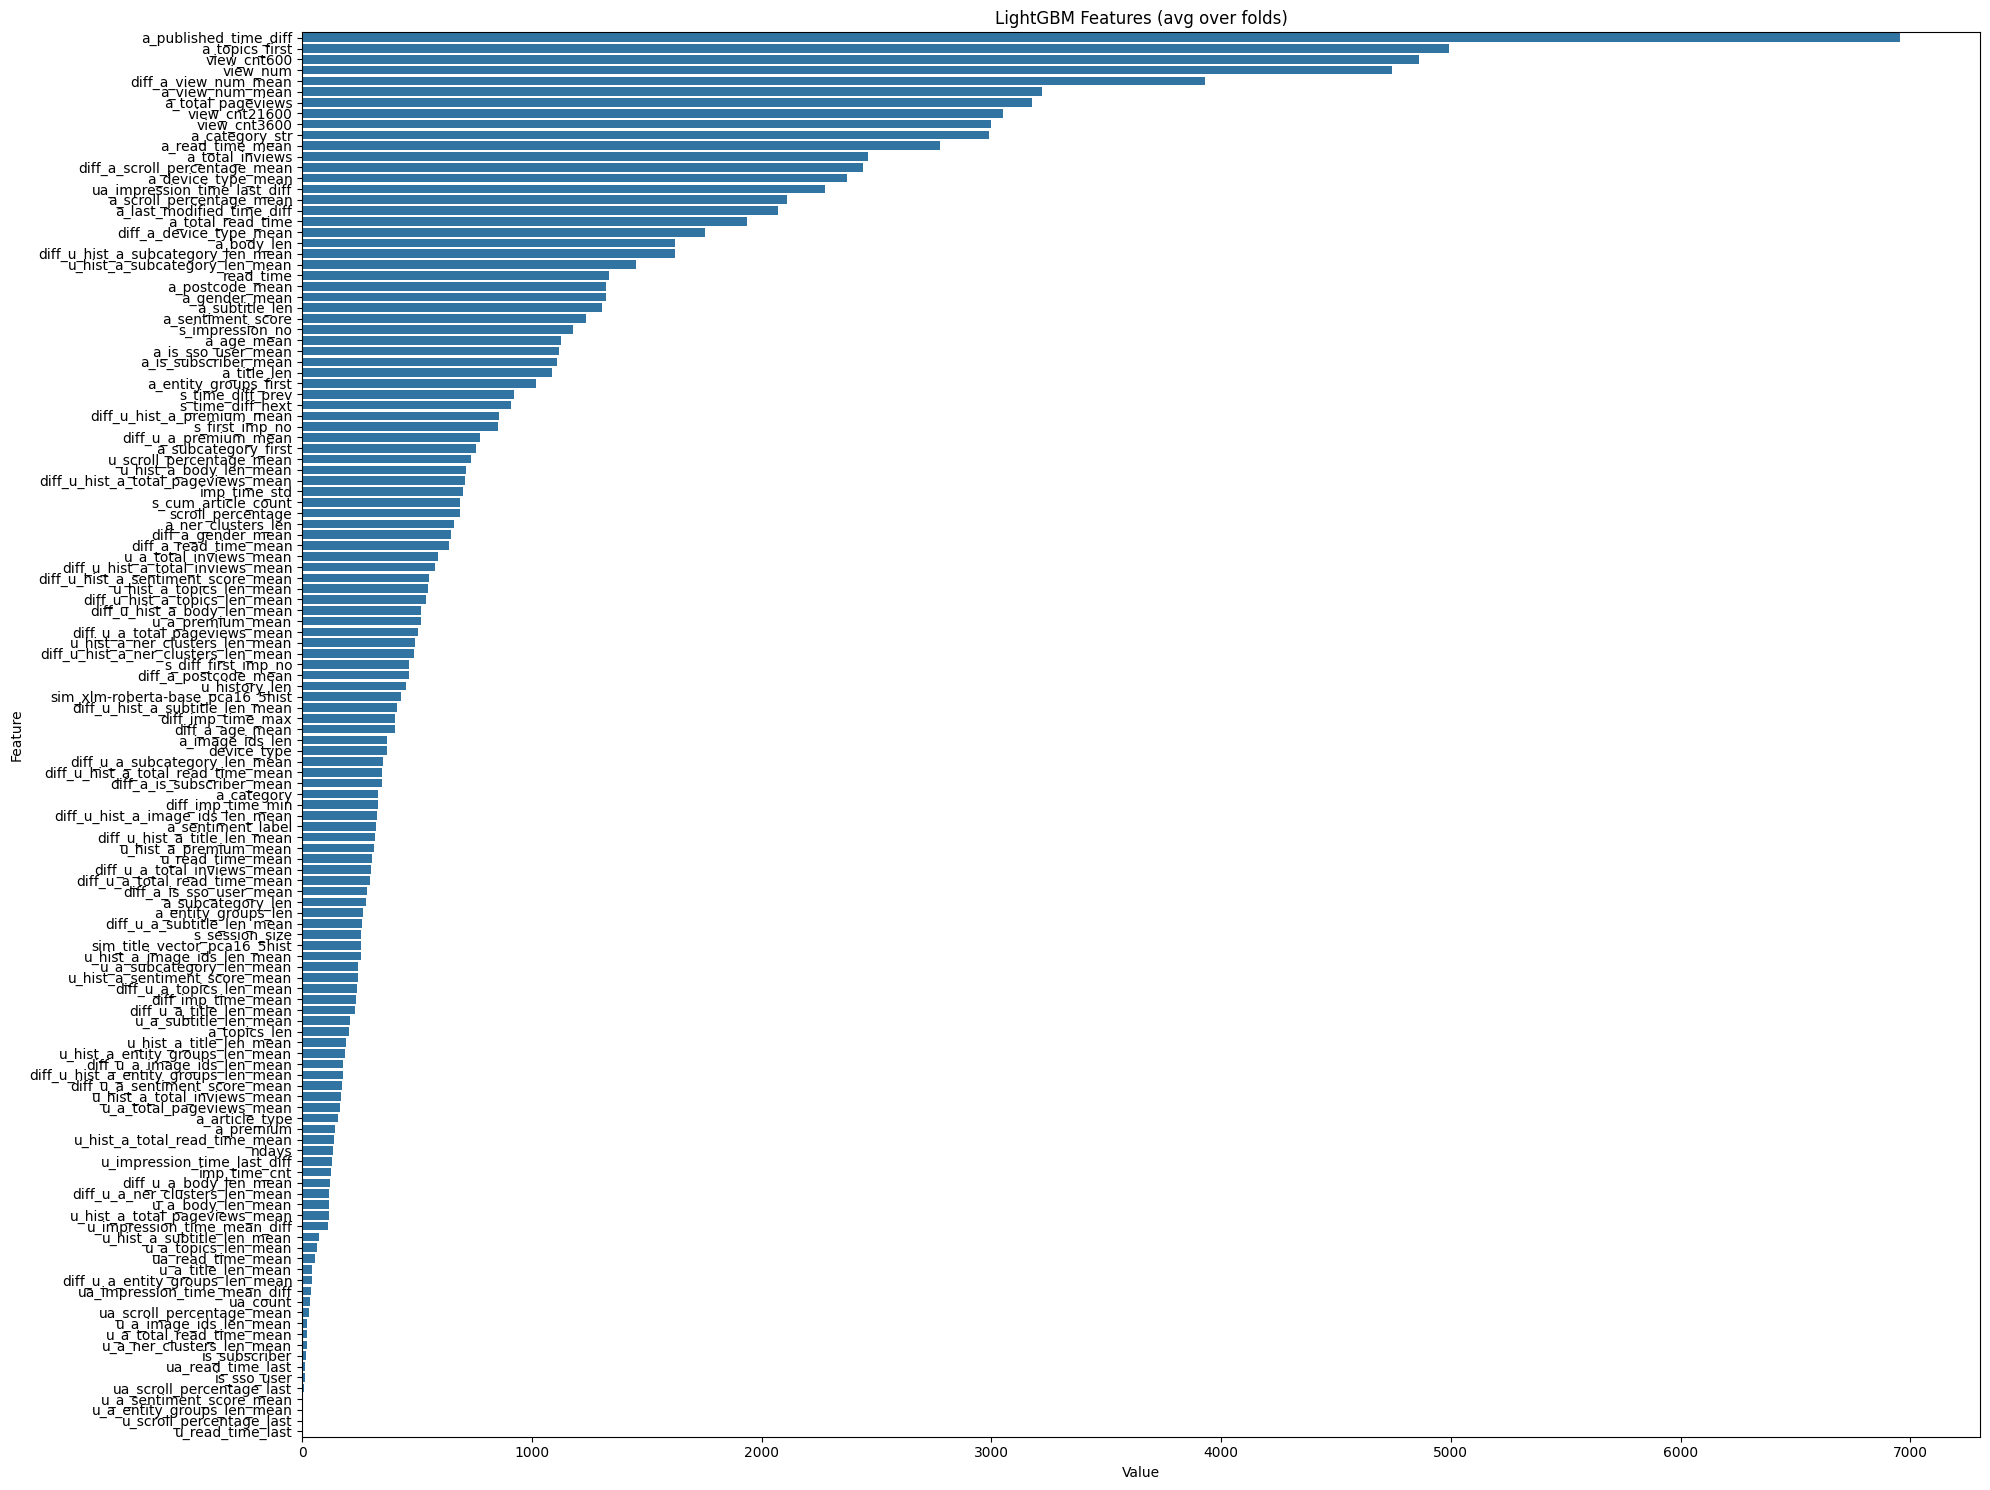

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp_split = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp_split.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

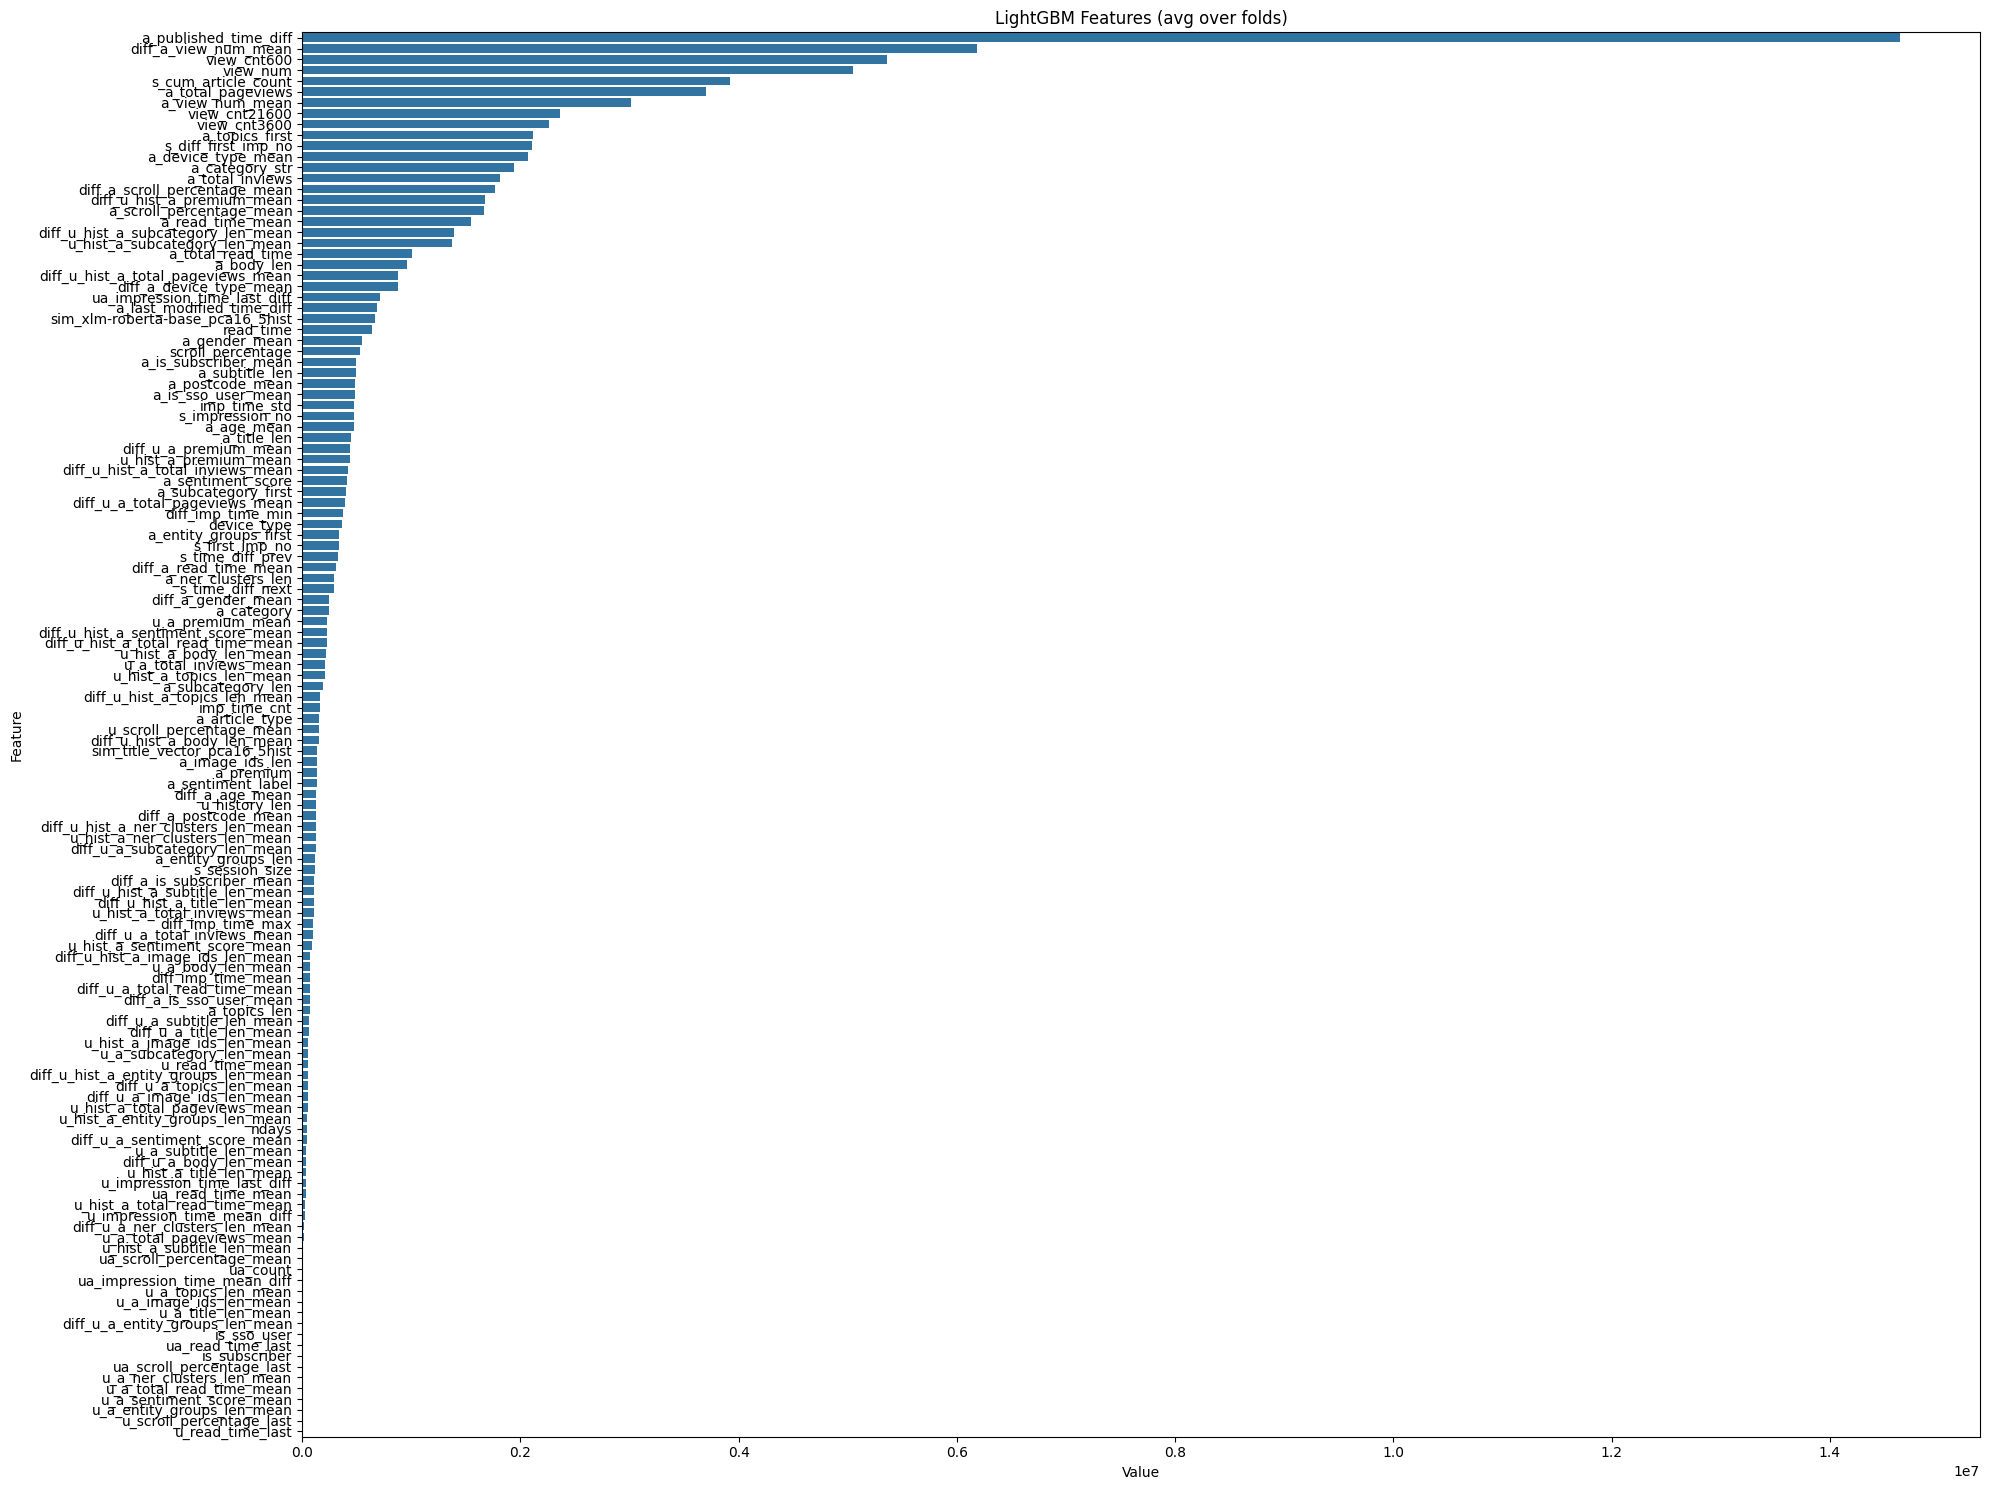

In [28]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance('gain'),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [29]:
feature_imp

,Value,Feature
0,0.000000e+00,u_read_time_last
1,0.000000e+00,u_scroll_percentage_last
2,6.063616e+02,u_a_entity_groups_len_mean
3,6.493767e+02,u_a_sentiment_score_mean
4,2.290253e+03,u_a_total_read_time_mean
5,2.558577e+03,u_a_ner_clusters_len_mean
6,3.509933e+03,ua_scroll_percentage_last
7,4.848990e+03,is_subscriber
8,5.113538e+03,ua_read_time_last
9,5.177306e+03,is_sso_user


In [30]:
# small data
# [68] training's ndcg@5: 0.68384	training's ndcg@10: 0.708506	valid_1's ndcg@5: 0.550625	valid_1's ndcg@10: 0.59301
# 90% negatie sampling [96]	training's ndcg@5: 0.70648	training's ndcg@10: 0.727916	valid_1's ndcg@5: 0.55037	valid_1's ndcg@10: 0.592454
# 80% [84] training's ndcg@5: 0.724863	training's ndcg@10: 0.743467	valid_1's ndcg@5: 0.546675	valid_1's ndcg@10: 0.589225
# 50% [48] training's ndcg@5: 0.791471	training's ndcg@10: 0.801367	valid_1's ndcg@5: 0.549047	valid_1's ndcg@10: 0.590969
# full data
# full, valid_frac=0.5 [72]	training's ndcg@5: 0.676216	training's ndcg@10: 0.701085	valid_1's ndcg@5: 0.554916	valid_1's ndcg@10: 0.596697
#	full, valid_frac=0.25	[72]	training's ndcg@5: 0.676216	training's ndcg@10: 0.701085	valid_1's ndcg@5: 0.555081	valid_1's ndcg@10: 0.596856 -> 0.25で問題なさそう
# under sampling: 0.8 [84]	training's ndcg@5: 0.718681	training's ndcg@10: 0.737356	valid_1's ndcg@5: 0.554494	valid_1's ndcg@10: 0.596234 -> いったんこれでいく
# under sampling: 0.5 [85]	training's ndcg@5: 0.791716	training's ndcg@10: 0.801159	valid_1's ndcg@5: 0.549173	valid_1's ndcg@10: 0.591309

# testに含まれないfeatureを使っていたので修正、featureの数40個ちょっと + bugちょっと修正
# small data
# [179]	training's ndcg@5: 0.727879	training's ndcg@10: 0.743617	valid_1's ndcg@5: 0.542041	valid_1's ndcg@10: 0.583972
# full data
# [71] valid_frac=0.25	training's ndcg@5: 0.666762	training's ndcg@10: 0.689943	valid_1's ndcg@5: 0.537423	valid_1's ndcg@10: 0.580449
# validで学習, [71]	training's ndcg@5: 0.649776	training's ndcg@10: 0.676771	valid_1's ndcg@5: 0.649776	valid_1's ndcg@10: 0.676771
# small data add feature
# [21]	training's ndcg@5: 0.673465	training's ndcg@10: 0.697794	valid_1's ndcg@5: 0.585802	valid_1's ndcg@10: 0.621771

# featureを40くらい->120に増やしてOptuna一回目、データ多すぎたのでfrac_train=0.6, valid=0.2, lr=0.02, importance=0もそこそこある -> itr増やすと数個に減る
# small data again, lr=0.05, early stopping=40
# [293]	training's ndcg@5: 0.785899	training's ndcg@10: 0.797273	valid_1's ndcg@5: 0.624458	valid_1's ndcg@10: 0.653404
# 0 feature削る (7個) -> 若干過学習っぽくなってる？いったん削るのやめる
# [497]	training's ndcg@5: 0.813702	training's ndcg@10: 0.823218	valid_1's ndcg@5: 0.62413	valid_1's ndcg@10: 0.652956

# dataのサイズがでかすぎるのが問題だが、出せる範囲でいったんsubしてみたい。
# full size tarin frac=0.6, valid=0.25, n features=120, lr=0.05
# [562]	training's ndcg@5: 0.756472	training's ndcg@10: 0.767894	valid_1's ndcg@5: 0.6163	valid_1's ndcg@10: 0.645803
# full size importance 0 削る (7個) -> いったん見送り
# [475]	training's ndcg@5: 0.753473	training's ndcg@10: 0.765269	valid_1's ndcg@5: 0.614346	valid_1's ndcg@10: 0.644336

# やり直し、small,lr=0.05, es=40, ちょっと結果変わった？
# [497]	training's ndcg@5: 0.812772	training's ndcg@10: 0.822199	valid_1's ndcg@5: 0.626575	valid_1's ndcg@10: 0.654959
# es=20
# [294]	training's ndcg@5: 0.786244	training's ndcg@10: 0.79764	valid_1's ndcg@5: 0.624717	valid_1's ndcg@10: 0.653553
# full
# lr=0.05, es=20, feature120, 以前のsubの再現性試す->だいたい合ってる
# [589]	training's ndcg@5: 0.757523	training's ndcg@10: 0.768813	valid_1's ndcg@5: 0.616694	valid_1's ndcg@10: 0.646198
# ner_luster_first削る -> よさげ！★
# [572]	training's ndcg@5: 0.749141	training's ndcg@10: 0.761131	valid_1's ndcg@5: 0.629459	valid_1's ndcg@10: 0.656884
# +view_num追加+importance3つ削除+weekday,sinceくわえる, featureの数は同じ ->ほぼ変わらないけど若干overfitぽい？
# [536]	training's ndcg@5: 0.749882	training's ndcg@10: 0.761709	valid_1's ndcg@5: 0.628889	valid_1's ndcg@10: 0.656824
# +view_num追加+importance3つ削除+sinceくわえる
# [521]	training's ndcg@5: 0.749625	training's ndcg@10: 0.761503	valid_1's ndcg@5: 0.628857	valid_1's ndcg@10: 0.656665
# +view_num追加+importance3つ削除
# [579]	training's ndcg@5: 0.749983	training's ndcg@10: 0.761819	valid_1's ndcg@5: 0.627416	valid_1's ndcg@10: 0.655384
# +view_num追加+weekday, since
# [500]	training's ndcg@5: 0.748611	training's ndcg@10: 0.760567	valid_1's ndcg@5: 0.627523	valid_1's ndcg@10: 0.655842
# +view_num追加 -> ちょっと過学習っぽい
# [466]	training's ndcg@5: 0.745985	training's ndcg@10: 0.758296	valid_1's ndcg@5: 0.627547	valid_1's ndcg@10: 0.655524
# 逆にview_cnt全部抜いたらどうなる？->流石にだめ
# [287]	training's ndcg@5: 0.720318	training's ndcg@10: 0.737377	valid_1's ndcg@5: 0.603957	valid_1's ndcg@10: 0.636707
# best+ 60%->70% data+80%negative sampling
# [381]	training's ndcg@5: 0.77904	training's ndcg@10: 0.788	valid_1's ndcg@5: 0.6196	valid_1's ndcg@10: 0.648867

# best まったく同じコードなのに何故かよくなった。怖いのでvalidは600で回す
# [640]	training's ndcg@5: 0.751232	training's ndcg@10: 0.762939	valid_1's ndcg@5: 0.630809	valid_1's ndcg@10: 0.658

# smallでsession feature追加、es=20, lr=0.05
# [463]	training's ndcg@5: 0.78685	training's ndcg@10: 0.797748	valid_1's ndcg@5: 0.658761	valid_1's ndcg@10: 0.681654
# full
# [671]	training's ndcg@5: 0.756055	training's ndcg@10: 0.767407	valid_1's ndcg@5: 0.643444	valid_1's ndcg@10: 0.668764 ★

# smallでndays追加->そんなにimporetance高くないけどちょっと上がった？
# [347]	training's ndcg@5: 0.772157	training's ndcg@10: 0.784023	valid_1's ndcg@5: 0.659202	valid_1's ndcg@10: 0.682168
# small user,articleごとのimpression time関連のfeature追加 (5個) -> 大幅に上昇
# [391]	training's ndcg@5: 0.780129	training's ndcg@10: 0.79148	valid_1's ndcg@5: 0.665083	valid_1's ndcg@10: 0.687932

# full, model.best_iteration=455
# [455]	training's ndcg@5: 0.750626	training's ndcg@10: 0.762692	valid_1's ndcg@5: 0.642833	valid_1's ndcg@10: 0.668778
# itr回数が減ったのでlr=0.03, es=40にしてみる
# [1183]	training's ndcg@5: 0.759565	training's ndcg@10: 0.770629	valid_1's ndcg@5: 0.64757	valid_1's ndcg@10: 0.672581


# roberta, 16dim, 3histのsimilarityのみ加えてみる gain:25216 -> importanceは高いけどスコアはそんなに
# [334]	training's ndcg@5: 0.773076	training's ndcg@10: 0.784843	valid_1's ndcg@5: 0.664366	valid_1's ndcg@10: 0.687189

# 32dim, gain: 27233 -> gainちょい上がった, でも計算コストとか考えていったん16dimでいこう
# [321]	training's ndcg@5: 0.770928	training's ndcg@10: 0.782964	valid_1's ndcg@5: 0.664096	valid_1's ndcg@10: 0.687402
# 16 dim + 5hist -> 3よりよさそう
# [379]	training's ndcg@5: 0.77892	training's ndcg@10: 0.790386	valid_1's ndcg@5: 0.665918	valid_1's ndcg@10: 0.688722
# 16 dim + 10 hist
# [383]	training's ndcg@5: 0.779094	training's ndcg@10: 0.790563	valid_1's ndcg@5: 0.665578	valid_1's ndcg@10: 0.688272
# 5dim yyama embed title gain: 12592.013440
# [404]	training's ndcg@5: 0.782042	training's ndcg@10: 0.793204	valid_1's ndcg@5: 0.666962	valid_1's ndcg@10: 0.689358

# small embedding2つ、user_embeddingのbug_fix
# [327]	training's ndcg@5: 0.772311	training's ndcg@10: 0.784261	valid_1's ndcg@5: 0.665132	valid_1's ndcg@10: 0.68791
# うーん微妙?

# Optunaやり直し
# small, lr=0.05, es=20 -> num_leaves増えたけどスコアは微妙, というかoverfitting?
# [269]	training's ndcg@5: 0.817333	training's ndcg@10: 0.826922	valid_1's ndcg@5: 0.658296	valid_1's ndcg@10: 0.682202
# full, 同じ条件 -> だめそうなので前のハイパラにしよう
# [760]	training's ndcg@5: 0.773442	training's ndcg@10: 0.78335	valid_1's ndcg@5: 0.639658	valid_1's ndcg@10: 0.665998 途中までだけど微妙

# full, embedding2つくわえる, es=40, lr=0.03 -> わずかにハイスコア seed=42, 最終subこれでいこう
# [1083]	training's ndcg@5: 0.758144	training's ndcg@10: 0.769417	valid_1's ndcg@5: 0.647657	valid_1's ndcg@10: 0.672747 ★
# valid [1083]	training's ndcg@5: 0.738256	training's ndcg@10: 0.752931	valid_1's ndcg@5: 0.738256	valid_1's ndcg@10: 0.752931
# seed=52
# [951]	training's ndcg@5: 0.75587	training's ndcg@10: 0.767383	valid_1's ndcg@5: 0.644426	valid_1's ndcg@10: 0.670112
# valida [951]	training's ndcg@5: 0.73536	training's ndcg@10: 0.750355	valid_1's ndcg@5: 0.73536	valid_1's ndcg@10: 0.750355
# seed=62
# [1109]	training's ndcg@5: 0.758555	training's ndcg@10: 0.769772	valid_1's ndcg@5: 0.648277	valid_1's ndcg@10: 0.673113
# [1109]	training's ndcg@5: 0.738603	training's ndcg@10: 0.753259	valid_1's ndcg@5: 0.738603	valid_1's ndcg@10: 0.753259


















